# Documentation to support the publication: "Modernizing the US National Fire Danger Rating System (Version 4): Simplified Fuel Models and Improved Live and Dead Fuel Moisture Calculations"

## Purpose: Evaluate the Growing Season Index-based Live Fuel Moisture Model used in NFDRS Version 4.0 and show a simple method for calibrating the model used field measurements of LFMC.

### Original Notebook edited to add three more LFMC sites for comparison as per reviewer recommendations. (WMJ, 25 July 2024)

<font size=5>NFDRSV4-TechDoc-LiveFuelMoistureEvaluation-Calibration.ipynb</font><br>
W. Matt Jolly, PhD, william.jolly@usda.gov<br>
Patrick H. Freeborn, PhD,  patrick.h.freeborn@usda.gov<br>
USDA Forest Service<br>
RMRS Fire Sciences Laboratory<br>
Fire, Fuel and Smoke Program<br>
5775 Hwy 10 W<br>
Missoula, MT 59808<br>


In [1]:
import math, sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import *
from scipy.stats import spearmanr,stats,linregress
from sklearn.metrics import mean_absolute_error,r2_score
from pandas.plotting import register_matplotlib_converters
import matplotlib.cm as cm
register_matplotlib_converters()
from matplotlib.dates import DateFormatter
from src.NFDRSV4PubGraphicsOptions import *

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

### Basic met functions, photoperiod and conversions

In [3]:
## fToC Converts Fahrenheit to Celcius
## Inputs: f: Temperature in deg F
## Returns: c: Temperature in deg C
def fToc(f):
    return (f -32) * 5/9

## cTof Converts Celcius to Fahrenheit
## Inputs: c: Temperature in deg C
## Returns: f: Temperature in deg F
def cTof(c):
    return (c * 9/5) + 32
INC = 0	#GSI Function Types, Increasing (Tmin, Dayl)
DEC = 1 #GSI Function Types, Decreasing (VPD)
MM_2_IN = 0.0393701  # Conversion factor from mm to inches
KPH_2_MPH = 0.621371 # Conversion factor from KPH to MPH

## Calculate the Photoperiod/Daylength from latitude and day of year (yearday)
## Inputs: lat: Latitude in Degrees (90 to -90)
##         yday: Yearday (1-366)
def CalcDayl(lat,yday):
    RADPERDAY = 0.017214
    RADPERDEG = 0.01745329
    MINDECL = -0.4092797
    SECPERRAD = 13750.9871
    DAYSOFF = 10.25
    # Daylength function from MT-CLIM */
    lat = lat * RADPERDEG
    if lat > 1.5707:
        lat = 1.5707
    if lat < -1.5707:
        lat = -1.5707
    coslat = math.cos(lat)
    sinlat = math.sin(lat)

    #* calculate cos and sin of declination */
    decl = MINDECL * math.cos((yday + DAYSOFF) * RADPERDAY)
    cosdecl = math.cos(decl)
    sindecl = math.sin(decl)
    cosegeom = coslat * cosdecl
    sinegeom = sinlat * sindecl
    coshss = -(sinegeom) / cosegeom
    if coshss < -1.0:
        coshss = -1.0  # 24-hr daylight */
    if coshss > 1.0:
        coshss = 1.0    # 0-hr daylight */
    hss = math.acos(coshss)                # hour angle at sunset (radians) */
    #* daylength (seconds) */
    return 2.0 * hss * SECPERRAD

# Function to calculate the Saturation Vapor Pressure for a given temperature.
# Note: Function converts internally from F to C.
# Input: tempF: Temperature in Deg F
# Return: Saturation Vapor Pressure (Pa)
def CalcVP(tempF):
    tmpC =  (tempF - 32.0) / 1.8
    vp = 610.7 * math.exp((17.38 * tmpC)/(239 + tmpC))
    return vp

# Calculate the VPD from RH and temperature
# Inputs: RH: Relative Humidity in Percent (1-100)
#         TempF: Temperature in Deg F
# Return: Vapor Pressure Deficit (Pa)
def CalcVPD(RH, TempF):
    vp = CalcVP(TempF)
    vpd = vp - (RH / 100) * vp
    if(vpd < 0.0):
        vpd = 0.0;
    return vpd



# GSI Functions

In [4]:
# A class to contains all of the parameters used to derived GSI.  This makes it easier to iterate through parameter spaces for
# for optimization
class GSILimits:
    TminLow = -2       # Lower limit for minimum temperature (C)
    TminUp = 5         # Upper limit for minimum temperature (C)
    DaylLow = 36000    # Lower limit for daylength (seconds)
    DaylUp = 39600     # Upper limit for daylength (seconds)
    VPDLow = 900       # Lower limit for VPD (pascals)
    VPDUp = 4100       # Upper limit for VPD (pascals)
    PrcpRTLow = 0    # Lower limit for running total precip (inches)
    PrcpRTUp = 0.393701  # Upper limit for running total precip (inches)... defaults to 10mm
    PrcpRTPeriod = 28  # Running total period for precipitaiton (days)
    GSIPeriod = 28     # Running average period for final GSI (days)
    GUThresh = 0.2    # Green-up threshold (dim)
    LFMMax = 200       # Maximum fuel moisture (% dry wt)
    LFMMin = 60        # Minimum fuel moisture (% dry wt)
    Lat = 45           # Station latitude (degrees)

In [5]:
# Helper function to set the GSI Limits class values based on the list of calibrated parameters
# gsilim: An instance of the GSILimits class
# gsiparams: an 11 element list of GSI parameters
# LFMMin: minimum live fuel moisture limit for model
# LFMMax: maximum live fuel moisture limit for model
# Lat: Latitude of the estimatation location (used in photoperiod calculations)
def SetGSILimits(gsilim,gsiparams,LFMMin,LFMMax, Lat):
    gsilim.TminLow = gsiparams[0] 
    gsilim.TminUp = gsiparams[1]
    gsilim.VPDLow = gsiparams[2]
    gsilim.VPDUp = gsiparams[3]
    gsilim.DaylLow = gsiparams[4]
    gsilim.DaylUp = gsiparams[5]
    gsilim.PrcpRTLow = gsiparams[6]
    gsilim.PrcpRTUp = gsiparams[7]
    gsilim.GSIPeriod = gsiparams[8]
    gsilim.GUThresh = gsiparams[9]
    gsilim.PrcpRTPeriod = gsiparams[10]
    gsilim.LFMMin = LFMMin
    gsilim.LFMMax = LFMMax
    gsilim.Lat = Lat
    return gsilim

## Ramp function for GSI calculations

In [6]:
# GSI indicator/ramp function
def Ind(Var,Low,Up):
    # Make sure all the input variables are numbers
    Var = float(Var)
    Low = float(Low)
    Up = float(Up)
    if(Up == Low):  # Upper (Up) and Lower (Low) can't be the same
        return 0
    if( Var < Low):  # If the variables is less than the lower limit, return 0
        return 0
    elif(Var > Up):  # If the variables is greater than the upper limit, return 1
        return 1
    else:            # If the variables is between the lower and upper limits, return the proportion
        return (Var - Low) / (Up - Low)

## Transform GSI to LFMC

### GSI is scaled to LFMC using a simple linear transform above a threshold value.  The min and max LFMC values are fuel type specific and are carried over from previous versions of the USNFDRS.

In [7]:
## Function to transform GSI to LFMC
def CalcLFMFromGSI(gsi,GUThresh,LFMMin,LFMMax):
    m = (LFMMax - LFMMin) / (1 - GUThresh)
    b = LFMMax - m
    # Scale GSI between min and max LFMC if gsi is above the green-up threshold
    if(gsi >= GUThresh):
        LFM = m*gsi + b
    # Below the Green-up Threshold, set the value to minimum LFM
    else:
        LFM = LFMMin
    return(LFM)

## Function to calculate the Growing Season Index

In [8]:
# Function to calculate GSI, Scaled GSI and Live Fuel Moisture on a DataFrame
# df: Pandas DataFrame of daily weather data
# assumes the following labeled columns: "Tmin: minimum temperature (deg F), VPDMax: Max daily VPD (Pa)
#                                          and Prcp: 24 hour total precipitation (Inches)"
# gsilim: An instance of the GSILimits class 
# PLowLim and PUpperLim: Date range for model predictions

def CalcGSI(df,gsilim,PLowLim='2014-01-01',PUpperLim = '2020-12-31'):
    # Filter the dataset for the period of interest (5 year period by default but can be adjusted with PLowLim and PUpperLim)
    df = df[(df['DateTime'] > PLowLim) & (df['DateTime'] <= PUpperLim)].copy()
    # Compute and store the day of the year for use in calculating Daylength
    df['JDay'] = df.DateTime.dt.dayofyear
    
    # Minimum Temperature
    df['TminC'] =  (df.Tmin - 32.0) * 5.0 / 9.0; # Convert Tmin from Fahrenheit to celcuius
    df['TminInd'] = df.apply(lambda row: Ind(row['TminC'],gsilim.TminLow,gsilim.TminUp),axis=1)
    # Vapor Pressure Deficit
    df['VPDInd']= df.apply(lambda row: 1 - Ind(row['VPDMax'],gsilim.VPDLow,gsilim.VPDUp),axis=1)
    # Photoperiod / Daylength
    # First, calculate the Daylength for each observation day (this uses site latitude and julian day)
    df['Dayl'] = df.apply(lambda row: CalcDayl(gsilim.Lat,row['JDay']),axis=1)  
    df['DaylInd']= df.apply(lambda row: Ind(row['Dayl'],gsilim.DaylLow,gsilim.DaylUp),axis=1)
    # Running Total Precipitation
    df['Prcp_RT'] = df['Prcp'].rolling(gsilim.PrcpRTPeriod).sum()
    df['PrcpInd'] = df.apply(lambda row: Ind(row['Prcp_RT'],gsilim.PrcpRTLow,gsilim.PrcpRTUp),axis=1)

    #################################################################                  
    # Daily GSI for four ramp model
    df['iGSI_PE'] = df['TminInd'] * df['VPDInd'] * df['DaylInd'] * df['PrcpInd']
    # Smoothed GSI (running average over the GSIPeriod)
    df['GSI_PE'] = df['iGSI_PE'].rolling(gsilim.GSIPeriod).mean()
    # Rescale the final GSI time series
    df['GSI_PE_RS'] = df['GSI_PE']/ df['GSI_PE'].quantile(1)

    # Calculate LFMC from Rescaled GSI
    df['LFMC'] = df.apply(lambda row: CalcLFMFromGSI(row['GSI_PE_RS'],gsilim.GUThresh,gsilim.LFMMin, gsilim.LFMMax),axis=1)
    return df


## Function to calculate and compare GSI using weather obs, measured LFMC and a set of GSI-LFM parameters

In [9]:
# Function to provide a bounded list of lower and upper values that ensures 
# that min is always less than max
# To be used in a Grid Search Optimization for GSI parameters
def MakeParamRange(minValue,maxValue,interv):
    lower = []
    upper = []
    for x in range(minValue,maxValue+1,interv): 
        for y in range(minValue,maxValue+1,interv):
            if(x < y):
                #print(paste(x,y))
                lower.append(x)
                upper.append(y)
    d = {'Lower': lower, 'Upper': upper}
    df = pd.DataFrame(data=d)
    return(df)
    

In [10]:
# Produce a table entry comparing 78 and GSI/GSIp LFM to Observations
def MakeGSILFMCompareTable4Param(Temp,LFMObs,BestParams,label="",UseLFMMinMax = True,Herb=True,Lat=45,PLowLim='2015-01-01',PUpperLim='2019-12-31'):
    #PLowLim='2015-01-01'
    #PUpperLim = '2019-12-31'
    
    # Label the DataFrame columns so they match the GSI function
    Temp = Temp.rename(columns={"MinT": "Tmin", "VPDM": "VPDMax", "Rain":"Prcp"})
    # Lookup the appropriate live fuel moisture ranges
    LFMMin,LFMMax = GetLFMRange(LFMObs,UseLFMMinMax,Herb)

    # Create the GSILimits structure as a default and then overwrite the variables we need to change
    gsilim = GSILimits
    newgsilim = SetGSILimits(gsilim,BestParams,LFMMin,LFMMax,Lat)
    
    # Calculate the GSI
    t = CalcGSI(Temp,newgsilim,PLowLim,PUpperLim)
    
    # Assign the components back to the dataframe
    Temp['GSI_PE_RS'] = t['GSI_PE_RS']
    Temp['LFMC'] = t['LFMC']  
    Temp['TminInd'] = t['TminInd']
    Temp['VPDInd'] = t['VPDInd']
    Temp['DaylInd'] = t['DaylInd']
    Temp['PrcpInd'] = t['PrcpInd']
    
    # Merge the GSI and LFM obs dataframes
    MetLFMMerge = LFMObs.merge(Temp, left_on='DateTime', right_on='DateTime', suffixes=(False, False))
   
    # Trim the dataset to the analysis date range
    MetLFMMerge = MetLFMMerge[(MetLFMMerge['DateTime'] > PLowLim) & (MetLFMMerge['DateTime'] <= PUpperLim)]
    
    # Compare the GSI-LFMC (NFDRS-V4) to measured LFMC
    s2,p2 = spearmanr(MetLFMMerge['Percent'],MetLFMMerge['LFMC'],nan_policy="omit")
    mae2 = mean_absolute_error(MetLFMMerge['Percent'], MetLFMMerge['LFMC'])
    slope, intercept, r_value, p_value_def, std_err = linregress(MetLFMMerge['Percent'],MetLFMMerge['LFMC'])
    r2 = r_value**2                                        
    print(r2)
    # Compare the old LFMC (NFDRS V2) to measure LFMC
    if Herb:
        s3,p3 = spearmanr(MetLFMMerge['Percent'],MetLFMMerge['FMH'])
        slope, intercept, r_value, p_value_def, std_err = linregress(MetLFMMerge['Percent'],MetLFMMerge['FMH'])
        r3 = r_value**2
        mae3 = mean_absolute_error(MetLFMMerge['Percent'], MetLFMMerge['FMH'])
    else:
        s3,p3 = spearmanr(MetLFMMerge['Percent'],MetLFMMerge['FMW'])
        slope, intercept, r_value, p_value_def, std_err = linregress(MetLFMMerge['Percent'],MetLFMMerge['FMW'])
        r3 = r_value**2
        mae3 = mean_absolute_error(MetLFMMerge['Percent'], MetLFMMerge['FMW'])
    
    return([label,round(s2,3),round(p2,3),round(mae2,3),round(r2,3),round(s3,3),round(p3,3),round(mae3,3),round(r3,3),len(MetLFMMerge['Percent'])])

## Function to perform a Grid Search Optimization of the GSI by best fit to field measurements

In [11]:
def GridSearchOptimizeGSILFM(Temp,LFMDat,label,maxSim = 2,mySeed = 123456,UseLFMMinMax = False,Herb=True,PInt = 20,PLowLim='2015-01-01',PUpperLim='2019-12-31',Lat=45):
    DEBUG = False
      
    # Create a range of smoothing / running precip period length ranges intervals
    smint = range(21,60,7)
    dfsmint = pd.DataFrame(data={'SMInt': smint})
    
    #### Get a Random Set of Parameters
    # Make the VPD ranges
    iVPDP = MakeParamRange(500, 9000, 500)  # VPD ranges from 500 to 9000 Pascals
    # Make the Temperature ranges
    iTMinP = MakeParamRange(-5, 10,1)  # MinT ranges from -5 to 10 deg C
    # Make the Daylength Ranges
    iDaylP = MakeParamRange(32400,46800,3600)  # Dayl ranges from 9 to 13 hours
    # Make the Prcp ranges
    iPrcpP = MakeParamRange(0,50,1)
    iPrcpP = (iPrcpP/10)  # Precip ranges from 0 to 5 inches

    # Make the green-up threshold 
    iThreshP = []
    for i in range(0,81,10):
        iThreshP.append(float(i/100))
    iThreshP = pd.DataFrame(data={'iThresh': iThreshP})    
    
    BestS = 0
    BestParams = []
    
    for i in range(0,maxSim):
        
        rs = dfsmint.sample(n=1,random_state=mySeed+i)
        smint = rs.iloc[0].SMInt.astype(int)
        
        # VPD Params
        rs = iVPDP.sample(n=1,random_state=mySeed+i)
        iVPDMin = rs.iloc[0].Lower
        iVPDMax = rs.iloc[0].Upper
        
        # TMin Params
        rs = iTMinP.sample(n=1,random_state=mySeed+i)
        iTminMin = rs.iloc[0].Lower
        iTminMax = rs.iloc[0].Upper

        # Daylength Params
        rs = iDaylP.sample(n=1,random_state=mySeed+i)
        iDaylMin = rs.iloc[0].Lower
        iDaylMax = rs.iloc[0].Upper

        # RT Precip Params
        rs = iPrcpP.sample(n=1,random_state=mySeed+i)
        iPrcpMin = rs.iloc[0].Lower
        iPrcpMax = rs.iloc[0].Upper

        # Greenup Threshold 
        rs = iThreshP.sample(n=1,random_state=mySeed+i)
        iThreshVal = rs.iloc[0].iThresh.astype(float)
        
        Params = [iTminMin,iTminMax,iVPDMin,iVPDMax,iDaylMin,iDaylMax,iPrcpMin,iPrcpMax,smint,iThreshVal,smint]
               
        S =  MakeGSILFMCompareTable4Param(Temp,LFMDat,Params,label=label,UseLFMMinMax = UseLFMMinMax,Herb=Herb,PLowLim=PLowLim,PUpperLim=PUpperLim,Lat=Lat)
        
        if(S[1] > BestS):
            BestS = S[1]
            BestParams = Params
           
        if i % PInt == 0:
            print(S,BestS,BestParams)
    return(BestParams)
       

### Input file helper functions for observed LFMC and met data files

In [12]:
# Helper function for reading the NFMD measured live fuel moisture data 
def ReadNFMDData(filename):
        # Read in data
        data = pd.read_csv(filename, sep='\t')
        data['DateTime']=pd.to_datetime(data['Date'].astype(str) + " 13", format='%Y-%m-%d %H')
        return data 

# Helper function for reading the export files from the Fuel Moisture Repository
def ReadFMRData(filename):
        # Read in data
        #colspecs = [(0, 8), (9, 13), (13, 25), (25, 53), (53, 65), (65, 73)]
        data = pd.read_csv(filename)
        data['DateTime']=pd.to_datetime(data['DATE'].astype(str) + " 13", format='%Y-%m-%d %H')
        return data 


# Helper function for reading the NFMD measured live fuel moisture data 
def ReadNFMDData(filename):
        # Read in data
        colspecs = [(0, 8), (9, 13), (13, 25), (25, 53), (53, 65), (65, 73)]
        data = pd.read_csv(filename, sep='\t')
        data['DateTime']=pd.to_datetime(data['Date'].astype(str) + " 13", format='%Y-%m-%d %H')
        return data 
# Helper function to derive historical min and max LFMC value from a NFMD set of measurements
def GetLFMRange(LFMObs,UseLFMMinMax,Herb):
    # Set the default green-up threshold and min / max live fuel moisture
    if not UseLFMMinMax:
        if Herb:
            LFMMin = 30
            LFMMax = 250
        else:
            LFMMin = 60
            LFMMax = 200
    else:
        LFMMin = LFMObs['Percent'].quantile(0.01).astype(int)
        LFMMax = LFMObs['Percent'].quantile(0.99).astype(int)
    return(LFMMin,LFMMax)

# Helper function for reading the FireFamily+ weather data and formatting columns corrected for use as Pandas dataframes
def GetMet(inFileName,Lat,delLast=False):
    Met = pd.read_csv(inFileName)

    Met.rename(columns=lambda x: x.strip(), inplace=True)
    ind = len(Met.columns)
    print(ind)
    if delLast:
        Met=Met.drop(Met.columns[[ind - 1]],axis=1)
    Met['DateTime']=pd.to_datetime(Met['DATE'].astype(str) + " 13", format='%m/%d/%Y %H')
    MaxRain = float(Met['Rain'].quantile([0.999]).values)
    #print(MaxRain)
    Met['Rain'].values[Met['Rain'] > MaxRain] = MaxRain
    Met['RunSumPrcp'] = Met['Rain'].rolling(28).sum()
    # Data Prep
    Met['MinTC'] = fToc(Met['MinT'])
    JDay = []
    Dayl = []
    for index, row in Met.iterrows():
        jday = int(row.DateTime.strftime(format="%j"))
        JDay.append(jday)
        dayl = CalcDayl(Lat,jday) 
        Dayl.append(dayl)
    Met['Dayl'] = Dayl
    Met['JDay'] = JDay
    return Met

### Simple GSI calc function that works on the 

In [13]:
def CalcGSIPandas(Temp,Params,LFMMin,LFMMax,Lat):
    # Label the DataFrame columns so they match the GSI function
    Temp = Temp.rename(columns={"MinT": "Tmin", "VPDM": "VPDMax", "Rain":"Prcp"})
    gsilim = GSILimits
    newgsilim = SetGSILimits(gsilim,Params,LFMMin,LFMMax,Lat)
    
    # Calculate the GSI
    t = CalcGSI(Temp,newgsilim,PLowLim='2014-01-01',PUpperLim = '2024-12-31')

    Temp['GSI_PE_RS'] = t['GSI_PE_RS']
    Temp['LFMC'] = t['LFMC']  
    Temp['TminInd'] = t['TminInd']
    Temp['VPDInd'] = t['VPDInd']
    Temp['DaylInd'] = t['DaylInd']
    Temp['PrcpInd'] = t['PrcpInd']
    
    # Merge the GSI and LFM obs dataframes
    #MetLFMMerge = LFMObs.merge(Temp, left_on='DateTime', right_on='DateTime', suffixes=(False, False))
    return(Temp)

In [14]:
def MakeGSILFMCompareNew(Temp,LFMObs,BestParams,UseLFMMinMax = True,PLowLim='2015-01-01',PUpperLim = '2019-12-31',UsePrcp=False,Lat=45,Herb=False):
   
    # Label the DataFrame columns so they match the GSI function
    Temp = Temp.rename(columns={"MinT": "Tmin", "VPDM": "VPDMax", "Rain":"Prcp"}).copy()
   
    # Set the default green-up threshold and min / max live fuel moisture 
    LFMMin,LFMMax = GetLFMRange(LFMObs,UseLFMMinMax,Herb)
    #print({"UseLFMMinMax":UseLFMMinMax,"Herb":Herb,"LFMMin":LFMMin,"LFMMax":LFMMax})
    gsilim = GSILimits
    newgsilim = SetGSILimits(gsilim,BestParams,LFMMin,LFMMax,Lat)
    
    # Calculate the GSI
    t = CalcGSI(Temp,newgsilim,PLowLim=PLowLim,PUpperLim = PUpperLim)
    Temp['GSI_PE_RS'] = t['GSI_PE_RS']
    Temp['LFMC'] = t['LFMC']  
    Temp['TminInd'] = t['TminInd']
    Temp['VPDInd'] = t['VPDInd']
    Temp['DaylInd'] = t['DaylInd']
    Temp['PrcpInd'] = t['PrcpInd']
    
    # Merge and filter to limit date range
    MetLFMMerge = LFMObs.merge(Temp, left_on='DateTime', right_on='DateTime', suffixes=(False, False))
    MetLFMMerge = MetLFMMerge[(MetLFMMerge['DateTime'] > PLowLim) & (MetLFMMerge['DateTime'] <= PUpperLim)]
        
    if MetLFMMerge.LFMC.std() == 0:
        s2 = [-999.9]
        mae = 999.9
    else:
        s2,p2 = spearmanr(MetLFMMerge['Percent'],MetLFMMerge['LFMC']*100,nan_policy="omit")
        mae = mean_absolute_error(MetLFMMerge['Percent'], MetLFMMerge['LFMC'])

    return([s2,mae,MetLFMMerge])

def GetMetMerge(Met,LFMObs,BestParams,UseLFMMinMax,Lat=45,Herb=False,PLowLim='2015-01-01',PUpperLim = '2019-12-31'):
    UsePrcp = True
    LFMMin,LFMMax = GetLFMRange(LFMObs,UseLFMMinMax,Herb)
    #print(LFMMin,LFMMax)
    t = MakeGSILFMCompareNew(Met,LFMObs,BestParams,UseLFMMinMax,UsePrcp=UsePrcp,Lat=Lat,Herb=Herb,PLowLim=PLowLim,PUpperLim=PUpperLim)
    return( t[2])
    

# Station-based analyses and local Grid Search Optimization 

## Load the surface weather observations from the RAWS stations

In [15]:
# Read in the weather data and format them into Pandas dataframes
# Note: These data were created using FireFamily+ and they include the weather, Max VPD and the calculated NFDRS Version 2 live fuel moisture content

Lat421501 = 39.58
FName = r'./data/421501.csv'
Met421501 = GetMet(FName,Lat421501,True)

Lat045433 = 34.08
FName = r'./data/045433.csv'
Met045433 = GetMet(FName,Lat045433,True) 
Met045433 = Met045433.dropna()

LatSSFS = 44
FName = r'./data/SSFS.csv'
MetSSFS = GetMet(FName,LatSSFS,True)
MetSSFS = MetSSFS.drop('DATE',axis=1)

#https://wrcc.dri.edu/cgi-bin/rawMAIN.pl?sdTLUF 
Lat413509 = 31.313
FName = r'./data/413509.csv'
Met413509 = GetMet(FName,Lat413509,True)
Met413509 = Met413509.drop('DATE',axis=1)

Lat101303 = 46.5
FName = r'./data/101303.csv'
Met101303 = GetMet(FName,Lat101303,True)
Met101303 = Met101303.drop('DATE',axis=1)

11
11
8
8
8


## Load the Live Fuel Moisture Content field measurements from either the National Fuel Moisture Database or the Fuel Moisture Repository Webportal

In [16]:
# Read field-measured live fuel moisture values obtained from the US National Fuel Moisture Database
# These files were exported from the National Fuel Moisture Database
UT_ArtTri = ReadNFMDData("./data/EGBC_UT_FillmoreFieldOffice_SevierReservoir_SagebrushBasinBig_data.txt")
UT_BroTec = ReadNFMDData("./data/EGBC_UT_FillmoreFieldOffice_SevierReservoir_Cheatgrass_data.txt")
CA_AdeFas = ReadNFMDData("./data/SOCC_CA_LACounty_LaurelCanyon,Mt.Olympus_data.txt")

In [17]:
# Additional sites added per peer review recommendation (WMJ, 25 July 2024)
# Fuel Moisture Repository Webportal
# https://nfmdb.org/?&target=_blank
ID_PhyCap = ReadFMRData("./data/FMR_202407191615.csv").rename(columns={'PERCENT':'Percent'})
TX_IleVom = ReadFMRData("./data/FMR_202407221747.csv").rename(columns={'PERCENT':'Percent'})
SD_BroIne = ReadFMRData("./data/FMR_202407221751.csv").rename(columns={'PERCENT':'Percent'})

In [18]:
# GSI-LFMC default parameters
GU = 0.2
Days = 28
defParams = [-2, 5, 900, 4100, 36000, 39600, 0.394, 0.787, Days,GU,Days]

In [19]:
## Max number of simulations for Grid Search Optimizations
maxSims = 10000
## Random seed number to ensure results are random but repeatable
mySeed = 123456

These simulations have already been run and the results saved below. Using the mySeed parameter, they are randomly sampled but repeatable, so enabling SIM would re-run the Grid Search Optimization for each of the three species but should yield the same final parameter set.

In [20]:
SIM = False
if SIM:
    results_brotec = GridSearchOptimizeGSILFM(Met421501,UT_BroTec,"UT_BroTec",maxSim = maxSims,mySeed=mySeed,UseLFMMinMax = True,Herb=True,Lat=421501)
    results_arttri = GridSearchOptimizeGSILFM(Met421501,UT_ArtTri,"UT_ArtTri",maxSim = maxSims,mySeed=mySeed,UseLFMMinMax = True,Herb=False,Lat=421501)
    results_adefas = GridSearchOptimizeGSILFM(Met045433,CA_AdeFas,"CA_AdeFas",maxSim = maxSims,mySeed=mySeed,UseLFMMinMax = True,Herb=False,Lat=Lat045433)
    results_ilevom = GridSearchOptimizeGSILFM(Met413509,TX_IleVom,"TX_IleVom",maxSim = maxSims,mySeed=mySeed,UseLFMMinMax = True,Herb=False,PLowLim='2020-01-01',PUpperLim='2022-12-31',Lat=Lat413509)
    results_broine = GridSearchOptimizeGSILFM(MetSSFS,SD_BroIne,"SD_BroIne",maxSim = maxSims,mySeed=mySeed,UseLFMMinMax = True,Herb=True,PLowLim='2020-01-01',PUpperLim='2022-12-31',Lat=LatSSFS)
    results_phycap = GridSearchOptimizeGSILFM(Met101303,ID_PhyCap,"ID_PhyCap",maxSim = maxSims,mySeed=mySeed,UseLFMMinMax = True,Herb=False,PLowLim='2019-01-01',PUpperLim='2023-12-31',Lat=Lat101303)
else:
    # Load the stored Grid Search Optimized parameter sets for each of the three species. These can be re-run by setting SIM to True in this cell
    results_adefas = [0, 6, 500, 7000, 32400, 36000, 1.2, 4.8, 56, 0.0, 56]#[-4, 0, 2500, 4000, 32400, 36000, 1.5, 3.0, 55, 0.0, 55]
    results_brotec = [-5, -2, 1000, 4000, 32400, 36000, 0.7, 1.0, 49, 0.0, 49]#[-4, -1, 2000, 5500, 32400, 43200, 0.2, 0.8, 50, 0.2, 50]
    results_arttri = [-4, 0, 1000, 2500, 32400, 36000, 0.6, 4.3, 49, 0.0, 49]#[-5, -1, 2000, 4000, 32400, 43200, 0.1, 0.4, 59, 0.2, 59]
    results_ilevom = [-3, 7, 1000, 6000, 39600, 43200, 1.2, 4.4, 49, 0.5, 49]#[-3, 1, 1000, 8500, 36000, 43200, 1.1, 4.5, 50, 0.6, 50]
    results_broine = [-1, 8, 1000, 2000, 32400, 43200, 0.5, 1.9, 21, 0.1, 21]#[-1, 3, 1500, 7500, 39600, 46800, 0.3, 0.5, 25, 0.4, 25]
    results_phycap = [-5, -1, 2000, 4000, 32400, 43200, 0.1, 0.4, 42, 0.2, 42]#[-5, -2, 500, 2000, 36000, 46800, 1.2, 2.6, 48, 0.2, 48]

## Store the 'best' parameters for each site/species 

In [21]:
CA_AdeFasBestParams = results_adefas # Adenostam fasciculatum
UT_ArtTriBestParams = results_arttri # Artemesia tridentata
UT_BroTecBestParams = results_brotec # Bromus tectorum
TX_IleVomBestParams = results_ilevom # Ilex vomitoria
SD_BroIneBestParams = results_broine # Bromus inermis
ID_PhyCapBestParams = results_phycap # Physiocarpus capitatus

In [22]:
#MakeGSILFMCompareTable4Param(Met413509,TX_IleVom,[-4, -3, 2000, 6000, 39600, 43200, 0.5, 3.3, 45, 0.7, 45],label="TX_IleVomOpt",UseLFMMinMax = True,Herb=False,PLowLim='2020-01-01',PUpperLim='2022-12-31',Lat=Lat413509)

In [23]:
# Chamise Parameters
results_adefas

[0, 6, 500, 7000, 32400, 36000, 1.2, 4.8, 56, 0.0, 56]

In [24]:
# Cheatgrass Parameters
results_brotec

[-5, -2, 1000, 4000, 32400, 36000, 0.7, 1.0, 49, 0.0, 49]

In [25]:
# Sagebrush Parameters
results_arttri

[-4, 0, 1000, 2500, 32400, 36000, 0.6, 4.3, 49, 0.0, 49]

In [26]:
# Yaupon Parameters
results_ilevom

[-3, 7, 1000, 6000, 39600, 43200, 1.2, 4.4, 49, 0.5, 49]

In [27]:
# Smooth Brome parameters
results_broine

[-1, 8, 1000, 2000, 32400, 43200, 0.5, 1.9, 21, 0.1, 21]

In [28]:
# Ninebark Parameters
results_phycap

[-5, -1, 2000, 4000, 32400, 43200, 0.1, 0.4, 42, 0.2, 42]

# Create tables and figures from the NFDRS V4 tech doc

In [29]:
# Cheatgrass
temp1a =  MakeGSILFMCompareTable4Param(Met421501,UT_BroTec,defParams,label="UT_BroTecDefaults",UseLFMMinMax = False,Herb=True,Lat=Lat421501)
temp1b = MakeGSILFMCompareTable4Param(Met421501,UT_BroTec,UT_BroTecBestParams,label="UT_BroTecGSO",UseLFMMinMax = True,Herb=True,Lat=Lat421501)

# Sagebrush
temp2a =  MakeGSILFMCompareTable4Param(Met421501,UT_ArtTri,defParams,label="UT_ArtTriDefaults",UseLFMMinMax = False,Herb=False,Lat=Lat421501)
temp2b =  MakeGSILFMCompareTable4Param(Met421501,UT_ArtTri,UT_ArtTriBestParams,label="UT_ArtTriGSO",UseLFMMinMax = True,Herb=False,Lat=Lat421501)

# Chamise
temp3a =  MakeGSILFMCompareTable4Param(Met045433,CA_AdeFas,defParams,label="CA_AdeFasDefaults",UseLFMMinMax = False,Herb=False,Lat=Lat045433)
temp3b =  MakeGSILFMCompareTable4Param(Met045433,CA_AdeFas,CA_AdeFasBestParams,label="CA_AdeFasGSO",UseLFMMinMax = True,Herb=False,Lat=Lat045433)

# Yaupon
temp4a =  MakeGSILFMCompareTable4Param(Met413509,TX_IleVom,defParams,label="TX_IleVomDefaults",UseLFMMinMax = False,Herb=False,PLowLim='2020-01-01',PUpperLim='2022-12-31',Lat=Lat413509)
temp4b =  MakeGSILFMCompareTable4Param(Met413509,TX_IleVom,TX_IleVomBestParams,label="TX_IleVomGSO",UseLFMMinMax = True,Herb=False,PLowLim='2020-01-01',PUpperLim='2022-12-31',Lat=Lat413509)

# Smooth Brome 
temp5a =  MakeGSILFMCompareTable4Param(MetSSFS,SD_BroIne,defParams,label="SD_BroIneDefaults",UseLFMMinMax = False,Herb=True,PLowLim='2020-01-01',PUpperLim='2022-12-31',Lat=LatSSFS)
temp5b =  MakeGSILFMCompareTable4Param(MetSSFS,SD_BroIne,SD_BroIneBestParams,label="SD_BroIneGSO",UseLFMMinMax = True,Herb=True,PLowLim='2020-01-01',PUpperLim='2022-12-31',Lat=LatSSFS)

# Ninebark
temp6a =  MakeGSILFMCompareTable4Param(Met101303,ID_PhyCap,defParams,label="ID_PhyCapDefaults",UseLFMMinMax = False,Herb=False,PLowLim='2019-01-01',PUpperLim='2023-12-31',Lat=Lat101303)
temp6b =  MakeGSILFMCompareTable4Param(Met101303,ID_PhyCap,ID_PhyCapBestParams,label="ID_PhyCapGSO",UseLFMMinMax = True,Herb=False,PLowLim='2019-01-01',PUpperLim='2023-12-31',Lat=Lat101303)

0.6381955722489746
0.8756704883622166
0.5467308942649306
0.7386899743386844
0.5132834208839246
0.7162495275313058
0.20450188363337793
0.46075964802954106
0.6195839127766164
0.5827159521408624
0.44108235448895805
0.6001318783618874


## Reproduce stats for Table 10 from the Technical Document

In [30]:
data = [temp1a,temp1b,temp2a,temp2b,temp3a,temp3b,temp4a,temp4b,temp5a,temp5b,temp6a,temp6b]
pd.DataFrame(data, columns=["Site_Species","rho_GSI-LFMC","GSI-LFMC-pval","GSI-LFMC-MAE","GSI-LFMC-R2","rho_LFMC-V2","LFMC-V2-pval","LFMC-V2-MAE","LFMC-V2-R2","N"])

,Site_Species,rho_GSI-LFMC,GSI-LFMC-pval,GSI-LFMC-MAE,GSI-LFMC-R2,rho_LFMC-V2,LFMC-V2-pval,LFMC-V2-MAE,LFMC-V2-R2,N
0,UT_BroTecDefaults,0.789,0.000,27.558,0.638,0.289,0.032,68.580,0.078,55
1,UT_BroTecGSO,0.924,0.000,23.857,0.876,0.289,0.032,68.580,0.078,55
2,UT_ArtTriDefaults,0.749,0.000,37.858,0.547,-0.165,0.228,59.627,0.000,55
3,UT_ArtTriGSO,0.880,0.000,38.023,0.739,-0.165,0.228,59.627,0.000,55
4,CA_AdeFasDefaults,0.586,0.000,17.847,0.513,0.180,0.062,25.868,0.007,108
5,CA_AdeFasGSO,0.821,0.000,13.258,0.716,0.180,0.062,25.868,0.007,108
6,TX_IleVomDefaults,0.381,0.001,34.164,0.205,0.467,0.000,30.180,0.195,69
7,TX_IleVomGSO,0.727,0.000,17.815,0.461,0.467,0.000,30.180,0.195,69
8,SD_BroIneDefaults,0.781,0.000,34.312,0.620,0.865,0.000,69.995,0.653,21
9,SD_BroIneGSO,0.881,0.000,46.315,0.583,0.865,0.000,69.995,0.653,21


In [31]:
MM_UT_BroTecOpt = GetMetMerge(Met421501, UT_BroTec,UT_BroTecBestParams,UseLFMMinMax=True,Lat=Lat421501,Herb=True)
MM_UT_ArtTriOpt = GetMetMerge(Met421501, UT_ArtTri,UT_ArtTriBestParams,UseLFMMinMax=True,Lat=Lat421501)
MM_CA_AdeFasOpt = GetMetMerge(Met045433,CA_AdeFas,results_adefas,UseLFMMinMax=True,Lat=Lat045433)
MM_TX_IleVomOpt = GetMetMerge(Met413509,TX_IleVom,results_ilevom,UseLFMMinMax=True,Lat=Lat413509,PLowLim='2020-01-01',PUpperLim = '2023-12-31')
MM_SD_BroIneOpt = GetMetMerge(MetSSFS,SD_BroIne,results_broine,UseLFMMinMax=True,Lat=LatSSFS,PLowLim='2020-01-01',PUpperLim = '2022-12-31')
MM_ID_PhyCapOpt = GetMetMerge(Met101303,ID_PhyCap,ID_PhyCapBestParams,UseLFMMinMax=True,Lat=Lat101303,PLowLim='2019-01-01',PUpperLim = '2023-12-31')

# Assign either the Herb or Woody FM from Version 2 to the column "FM" for comparison across fuel types
MM_UT_BroTecOpt['FM'] = MM_UT_BroTecOpt['FMH']
MM_UT_ArtTriOpt['FM'] = MM_UT_ArtTriOpt['FMW']
MM_CA_AdeFasOpt['FM'] = MM_CA_AdeFasOpt['FMW']
MM_TX_IleVomOpt['FM'] = MM_TX_IleVomOpt['FMW']
MM_SD_BroIneOpt['FM'] = MM_SD_BroIneOpt['FMH']
MM_ID_PhyCapOpt['FM'] = MM_ID_PhyCapOpt['FMW']

In [32]:
print("LFMC Obs vs GSI-LFMC Sample Size Total: ",
      MM_UT_BroTecOpt.index.size + MM_UT_ArtTriOpt.index.size + 
      MM_CA_AdeFasOpt.index.size + MM_TX_IleVomOpt.index.size + 
      MM_SD_BroIneOpt.index.size + MM_ID_PhyCapOpt.index.size)

LFMC Obs vs GSI-LFMC Sample Size Total:  346


In [33]:
MM_UT_BroTecOpt['DateTime'] = pd.to_datetime(MM_UT_BroTecOpt['DateTime'],format='%Y-%m-%d %H:%M:%S')
MM_UT_ArtTriOpt['DateTime'] = pd.to_datetime(MM_UT_ArtTriOpt['DateTime'],format='%Y-%m-%d %H:%M:%S')
MM_CA_AdeFasOpt['DateTime'] = pd.to_datetime(MM_CA_AdeFasOpt['DateTime'],format='%Y-%m-%d %H:%M:%S')
MM_TX_IleVomOpt['DateTime'] = pd.to_datetime(MM_TX_IleVomOpt['DateTime'],format='%Y-%m-%d %H:%M:%S')
MM_SD_BroIneOpt['DateTime'] = pd.to_datetime(MM_SD_BroIneOpt['DateTime'],format='%Y-%m-%d %H:%M:%S')
MM_ID_PhyCapOpt['DateTime'] = pd.to_datetime(MM_ID_PhyCapOpt['DateTime'],format='%Y-%m-%d %H:%M:%S')

## Create Figure 5 from the NFDRS V4 technical document paper

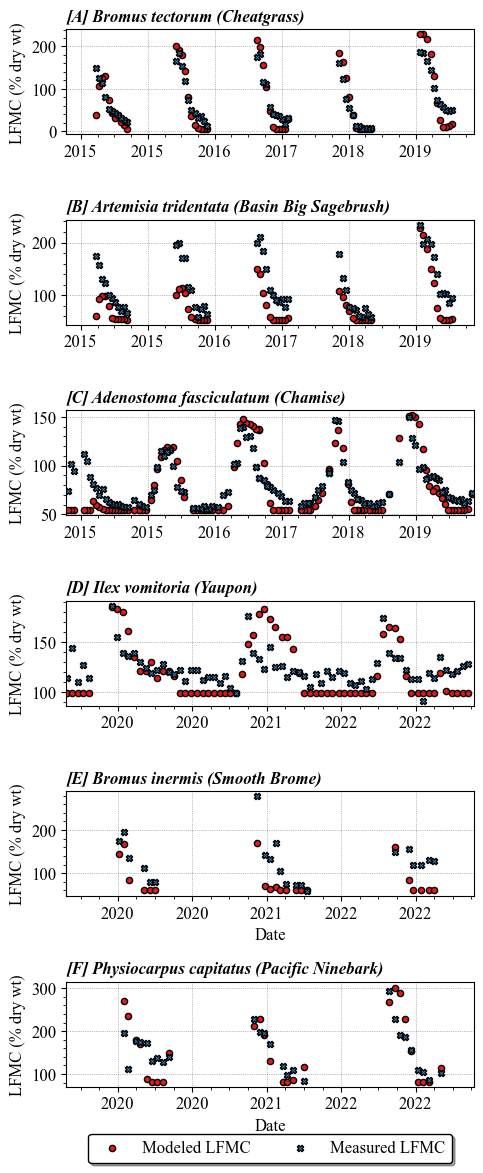

In [34]:
f,ax = plt.subplots(6,1,figsize=(5,12))
## Plot BroTec
MM_UT_BroTecOpt.plot.scatter(x='DateTime',y='LFMC',ax=ax[0],marker=mkr_nf1,color=clr_nf1, edgecolor=clr_edg_nf)
MM_UT_BroTecOpt.plot.scatter(x='DateTime',y='Percent',ax=ax[0],marker=mkr_nf2,color=clr_nf2, edgecolor=clr_edg_nf)
ax[0].set_xlim([datetime(2015, 1, 1), datetime(2019, 12, 31)])
ax[0].set_xlabel("")
ax[0].set_title("[A] Bromus tectorum (Cheatgrass)", style='italic')

# Define the date format
date_form = DateFormatter("%Y")
ax[0].xaxis.set_major_formatter(date_form)
# Setting the number of ticks
ax[0].xaxis.set_major_locator(plt.MaxNLocator(7))
ax[0].set_xlabel('')
ax[0].set_ylabel('LFMC (% dry wt)')

## Plot ArtTri
ax[1].set_title("[B] Artemisia tridentata (Basin Big Sagebrush)", style='italic')
MM_UT_ArtTriOpt.plot.scatter(x='DateTime',y='LFMC',ax=ax[1],marker=mkr_nf1,color=clr_nf1, edgecolor=clr_edg_nf)
MM_UT_ArtTriOpt.plot.scatter(x='DateTime',y='Percent',ax=ax[1],marker=mkr_nf2,color=clr_nf2, edgecolor=clr_edg_nf)
ax[1].set_xlim([datetime(2015, 1, 1), datetime(2019, 12, 31)])
ax[1].xaxis.set_major_formatter(date_form)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(7))
ax[1].set_xlabel('')
ax[1].set_ylabel('LFMC (% dry wt)')

## Plot AdeFas
ax[2].set_title("[C] Adenostoma fasciculatum (Chamise)", style='italic')
MM_CA_AdeFasOpt.plot.scatter(x='DateTime',y='LFMC',ax=ax[2],marker=mkr_nf1,color=clr_nf1, edgecolor=clr_edg_nf,label='Modeled LFMC',legend=False)
MM_CA_AdeFasOpt.plot.scatter(x='DateTime',y='Percent',ax=ax[2],marker=mkr_nf2,color=clr_nf2, edgecolor=clr_edg_nf,label='Measured LFMC',legend=False)
ax[2].set_xlim([datetime(2015, 1, 1), datetime(2019, 12, 31)])
ax[2].set_xlabel('')
ax[2].xaxis.set_major_locator(plt.MaxNLocator(7))
ax[2].xaxis.set_major_formatter(date_form)
ax[2].set_xlabel('')
ax[2].set_ylabel('LFMC (% dry wt)')

## Plot IleVom
plotind = 3
ax[plotind].set_title("[D] Ilex vomitoria (Yaupon)", style='italic')
MM_TX_IleVomOpt.plot.scatter(x='DateTime',y='LFMC',ax=ax[plotind],marker=mkr_nf1,color=clr_nf1, edgecolor=clr_edg_nf,label='Modeled LFMC',legend=False)
MM_TX_IleVomOpt.plot.scatter(x='DateTime',y='Percent',ax=ax[plotind],marker=mkr_nf2,color=clr_nf2, edgecolor=clr_edg_nf,label='Measured LFMC',legend=False)
ax[plotind].set_xlim([datetime(2020, 1, 1), datetime(2022, 12, 31)])
ax[plotind].xaxis.set_major_locator(plt.MaxNLocator(7))
ax[plotind].xaxis.set_major_formatter(date_form)
ax[plotind].set_xlabel("")
ax[plotind].set_ylabel('LFMC (% dry wt)')

## Plot BroIne
plotind = 4
ax[plotind].set_title("[E] Bromus inermis (Smooth Brome)", style='italic')
MM_SD_BroIneOpt.plot.scatter(x='DateTime',y='LFMC',ax=ax[plotind],marker=mkr_nf1,color=clr_nf1, edgecolor=clr_edg_nf,label='Modeled LFMC',legend=False)
MM_SD_BroIneOpt.plot.scatter(x='DateTime',y='Percent',ax=ax[plotind],marker=mkr_nf2,color=clr_nf2, edgecolor=clr_edg_nf,label='Measured LFMC',legend=False)
ax[plotind].set_xlim([datetime(2020, 1, 1), datetime(2022, 12, 31)])
ax[plotind].set_xlabel("Date")
ax[plotind].xaxis.set_major_locator(plt.MaxNLocator(7))
ax[plotind].xaxis.set_major_formatter(date_form)
ax[plotind].set_xlabel('Date')
ax[plotind].set_ylabel('LFMC (% dry wt)')


## Plot PhyCap
plotind = 5
ax[plotind].set_title("[F] Physiocarpus capitatus (Pacific Ninebark)", style='italic')
MM_ID_PhyCapOpt.plot.scatter(x='DateTime',y='LFMC',ax=ax[plotind],marker=mkr_nf1,color=clr_nf1, edgecolor=clr_edg_nf,label='Modeled LFMC')
MM_ID_PhyCapOpt.plot.scatter(x='DateTime',y='Percent',ax=ax[plotind],marker=mkr_nf2,color=clr_nf2, edgecolor=clr_edg_nf,label='Measured LFMC')
ax[plotind].set_xlim([datetime(2020, 1, 1), datetime(2022, 12, 31)])
ax[plotind].set_xlabel("Date")
ax[plotind].xaxis.set_major_locator(plt.MaxNLocator(7))
ax[plotind].xaxis.set_major_formatter(date_form)
ax[plotind].set_xlabel('Date')
ax[plotind].set_ylabel('LFMC (% dry wt)')
ax[5].legend(loc='upper center', bbox_to_anchor=(0.5, -0.37),
          fancybox=True, shadow=True, ncol=5)

## Write out the figure
f.tight_layout()
fout = "./outputs/CombinedGSILFMPlot6panel.png" 
if fout != "":
    plt.savefig(fout,dpi=300, bbox_inches='tight',facecolor='white', transparent=False )


In [35]:
# Note these use the default parameters for each species
MM_UT_BroTec = GetMetMerge(Met421501, UT_BroTec,defParams,UseLFMMinMax=True,Lat=Lat421501,Herb=True)
MM_UT_ArtTri = GetMetMerge(Met421501, UT_ArtTri,defParams,UseLFMMinMax=True,Lat=Lat421501)
MM_CA_AdeFas = GetMetMerge(Met045433,CA_AdeFas,defParams,UseLFMMinMax=True,Lat=Lat045433)
MM_TX_IleVom = GetMetMerge(Met413509,TX_IleVom,defParams,UseLFMMinMax=True,Lat=Lat413509,PLowLim='2020-01-01',PUpperLim = '2023-12-31')
MM_SD_BroIne = GetMetMerge(MetSSFS,SD_BroIne,defParams,UseLFMMinMax=True,Lat=LatSSFS,PLowLim='2020-01-01',PUpperLim = '2022-12-31')
MM_ID_PhyCap = GetMetMerge(Met101303,ID_PhyCap,defParams,UseLFMMinMax=True,Lat=Lat101303,PLowLim='2019-01-01',PUpperLim = '2023-12-31')

# Fix the first comparions against V2 LFMC's
MM_UT_BroTec['FM'] = MM_UT_BroTec['FMH']
MM_UT_ArtTri['FM'] = MM_UT_ArtTri['FMW']
MM_CA_AdeFas['FM'] = MM_CA_AdeFas['FMW']
MM_TX_IleVom['FM'] = MM_TX_IleVom['FMW']
MM_SD_BroIne['FM'] = MM_SD_BroIne['FMH']
MM_ID_PhyCap['FM'] = MM_ID_PhyCap['FMW']

# Create a simple dataframe for the correlation for both the default and Grid Search Op
MM_GSIDef = pd.concat([MM_UT_BroTec,MM_UT_ArtTri,MM_CA_AdeFas,MM_TX_IleVom,MM_SD_BroIne,MM_ID_PhyCap])
MM_GSIDef = MM_GSIDef[['Percent','LFMC','FM']]

MM_GSIOpt= pd.concat([MM_UT_BroTecOpt,MM_UT_ArtTriOpt,MM_CA_AdeFasOpt,MM_TX_IleVomOpt,MM_SD_BroIneOpt,MM_ID_PhyCapOpt])
MM_GSIOpt = MM_GSIOpt[['Percent','LFMC','FM']]


In [36]:
MM_Herb_GSIOpt =  pd.concat([MM_UT_BroTecOpt,MM_SD_BroIneOpt])
MM_Wood_GSIOpt = pd.concat([MM_UT_ArtTriOpt,MM_CA_AdeFasOpt,MM_TX_IleVomOpt,MM_ID_PhyCapOpt])

### Ranges of values for measured woody LFMC for Yaupon

In [37]:
MM_TX_IleVom.Percent.quantile([0,0.05,0.5,0.95,1])

0.00     91.0
0.05    104.4
0.50    121.0
0.95    151.0
1.00    186.0
Name: Percent, dtype: float64

## Ranges of values for measured herbaceous LFMC

In [38]:
MM_Herb_GSIOpt.Percent.quantile([0,0.05,0.5,0.95,1])

0.00      4.00
0.05     10.25
0.50     74.50
0.95    184.00
1.00    279.00
Name: Percent, dtype: float64

## Ranges of values for measured woody LFMC

In [39]:
MM_Wood_GSIOpt.Percent.quantile([0,0.05,0.5,0.95,1])

0.00     55.0
0.05     59.0
0.50    108.0
0.95    196.0
1.00    304.0
Name: Percent, dtype: float64

In [40]:
r2_score(MM_GSIDef['Percent'],MM_GSIDef['FM'])

-0.7739404438857747

## Correlations across all species using the Default GSI parameters

In [41]:
# Pooled correlation for all three species using default parameters
MM_GSIDef.corr(method='spearman')

,Percent,LFMC,FM
Percent,1.000000,0.779313,0.329860
LFMC,0.779313,1.000000,0.473494
FM,0.329860,0.473494,1.000000


In [42]:
slope, intercept, r_value_fm, p_value_def, std_err = linregress(MM_GSIDef['Percent'],MM_GSIDef['FM'])
print(r_value_fm**2,p_value)

NameError: name 'p_value' is not defined

In [ ]:
slope, intercept, r_value_def, p_value_def, std_err = linregress(MM_GSIDef['Percent'],MM_GSIDef['LFMC'])

In [ ]:
r_value_def**2

## Correlations across all species using the Grid Search Optimized GSI parameters at each site

In [ ]:
MM_GSIOpt.corr(method='spearman')

In [ ]:
slope, intercept, r_value_opt, p_value, std_err = linregress(MM_GSIOpt['Percent'],MM_GSIOpt['LFMC'])

In [ ]:
r_value_opt**2

## Create Figure 4 from the NFDRFS V4 technical document paper

In [ ]:
f,ax = plt.subplots(3,1,figsize=(5,12))
MM_UT_BroTec.plot.scatter(x='Percent',y='FMH',ax=ax[0],label="BroTec",marker=mkr_nf1,color=clr_nf1,edgecolor=clr_edg_nf)
MM_UT_ArtTri.plot.scatter(x='Percent',y='FMW',ax=ax[0],label="ArtTri",marker=mkr_nf2,color=clr_nf2,edgecolor=clr_edg_nf)
MM_CA_AdeFas.plot.scatter(x='Percent',y='FMW',ax=ax[0],label="AdeFas",marker=mkr_nf3,color=clr_nf3,edgecolor=clr_edg_nf)
MM_TX_IleVom.plot.scatter(x='Percent',y='FMW',ax=ax[0],label="IleVom",marker=mkr_nf4,color=clr_nf4,edgecolor=clr_edg_nf)
MM_SD_BroIne.plot.scatter(x='Percent',y='FMW',ax=ax[0],label="BroIne",marker=mkr_nf5,color=clr_nf5,edgecolor=clr_edg_nf)
MM_ID_PhyCap.plot.scatter(x='Percent',y='FMW',ax=ax[0],label="PhyCap",marker=mkr_nf6,color=clr_nf6,edgecolor=clr_edg_nf)
ax[0].plot([0,250],[0,250],color='black')
ax[0].legend(loc='upper left')
ax[0].set_xlabel("")
ax[0].set_ylabel("Modeled LFMC (% dry wt)")
ax[0].set_title('NFDRS Version 2 LFMC Model')

MM_UT_BroTec.plot.scatter(x='Percent',y='LFMC',ax=ax[1],marker=mkr_nf1,color=clr_nf1,edgecolor=clr_edg_nf)
MM_UT_ArtTri.plot.scatter(x='Percent',y='LFMC',ax=ax[1],marker=mkr_nf2,color=clr_nf2,edgecolor=clr_edg_nf)
MM_CA_AdeFas.plot.scatter(x='Percent',y='LFMC',ax=ax[1],marker=mkr_nf3,color=clr_nf3,edgecolor=clr_edg_nf)
MM_TX_IleVom.plot.scatter(x='Percent',y='LFMC',ax=ax[1],marker=mkr_nf4,color=clr_nf4,edgecolor=clr_edg_nf)
MM_SD_BroIne.plot.scatter(x='Percent',y='LFMC',ax=ax[1],marker=mkr_nf5,color=clr_nf5,edgecolor=clr_edg_nf)
MM_ID_PhyCap.plot.scatter(x='Percent',y='LFMC',ax=ax[1],marker=mkr_nf6,color=clr_nf6,edgecolor=clr_edg_nf)
ax[1].plot([0,250],[0,250],color='black')
#ax[1].legend(loc='lower left',bbox_to_anchor=(1.0, 1.0))
ax[1].set_xlabel("")
ax[1].set_ylabel("Modeled LFMC (% dry wt)")
ax[1].set_title('NFDRS Version 4 Default GSI Parameters')

MM_UT_BroTecOpt.plot.scatter(x='Percent',y='LFMC',ax=ax[2],marker=mkr_nf1,color=clr_nf1,edgecolor=clr_edg_nf)
MM_UT_ArtTriOpt.plot.scatter(x='Percent',y='LFMC',ax=ax[2],marker=mkr_nf2,color=clr_nf2,edgecolor=clr_edg_nf)
MM_CA_AdeFasOpt.plot.scatter(x='Percent',y='LFMC',ax=ax[2],marker=mkr_nf3,color=clr_nf3,edgecolor=clr_edg_nf)
MM_TX_IleVomOpt.plot.scatter(x='Percent',y='LFMC',ax=ax[2],marker=mkr_nf4,color=clr_nf4,edgecolor=clr_edg_nf)
MM_SD_BroIneOpt.plot.scatter(x='Percent',y='LFMC',ax=ax[2],marker=mkr_nf5,color=clr_nf5,edgecolor=clr_edg_nf)
MM_ID_PhyCapOpt.plot.scatter(x='Percent',y='LFMC',ax=ax[2],marker=mkr_nf6,color=clr_nf6,edgecolor=clr_edg_nf)
ax[2].plot([0,250],[0,250],color='black')
#ax[1].legend(loc='lower left',bbox_to_anchor=(1.0, 1.0))
ax[2].set_xlabel("Measured LFMC (% dry wt)")
ax[2].set_ylabel("Modeled LFMC (% dry wt)")
ax[2].set_title('NFDRS Version 4 Grid-Search Optimized GSI Parameters')

plt.tight_layout()
fout = './outputs/FuelMoistureComparisons_3Grid.png'
if fout != "":
    plt.savefig(fout,dpi=300, bbox_inches='tight',facecolor='white', transparent=False )


### The following code is just to demonstrate some aspects of the GSI calculations such as differences in the cumulative precip between locations and choice of threshold and smoothing period for optimizations.

In [ ]:
Met421501RunSumPrcp = Met421501.RunSumPrcp.dropna()
Met045433RunSumPrcp = Met045433.RunSumPrcp.dropna()

In [ ]:
# Calculate the cumulative proportion of the data that falls below each value
cumulative = np.linspace(0, 1, len(Met421501RunSumPrcp))
cumulative2 = np.linspace(0, 1, len(Met045433RunSumPrcp))
# Sort the data in ascending order
sorted_data = np.sort(Met421501RunSumPrcp)
sorted_data2 = np.sort(Met045433RunSumPrcp)

# Calculate the cumulative proportion of the sorted data
cumulative_data = np.cumsum(sorted_data) / np.sum(sorted_data)
cumulative_data2 = np.cumsum(sorted_data2) / np.sum(sorted_data2)


In [ ]:
# Plot the CDF
plt.plot(sorted_data, cumulative_data,label='Servier Reservoir, UT')
plt.plot(sorted_data2, cumulative_data2,label='Beverly Hills, CA')
# Add labels and title
plt.xlabel("Running Total Precip (in)")
plt.ylabel("Cumulative Proportion")
plt.legend()
plt.title("Cumulative Distribution Function (CDF) of Running Total Precip (in)")

In [ ]:
## Look up the percentiles of Cum Rainfall
print(stats.percentileofscore(Met421501.RunSumPrcp.dropna(), 0.393701))
print(stats.percentileofscore(Met421501.RunSumPrcp.dropna(), 1.1))
print(stats.percentileofscore(Met045433.RunSumPrcp.dropna(), 0.393701))
print(stats.percentileofscore(Met045433.RunSumPrcp.dropna(), 3.6))

In [ ]:
print(stats.percentileofscore(Met421501.RunSumPrcp.dropna(), 1.1))

In [ ]:
SIM = False
if SIM:
    # Test the default Green-up threshold 
    corrs = []
    DayRange = np.arange(7,100,7,dtype='int')
    for i in DayRange:
        print('Days: ', i)
        for j in range(0,10):
            GU = j / 10
            Days = int(i)
            #defParams = [-2, 5, 900, 4100, 36000, 39600, 0, 0.393701, Days,GU,Days]
            
            MM_UT_BroTec = GetMetMerge(Met421501, UT_BroTec,defParams,UseLFMMinMax=False,Lat=Lat421501, Herb=True)
            MM_UT_ArtTri = GetMetMerge(Met421501, UT_ArtTri,defParams,UseLFMMinMax=False,Lat=Lat421501)
            MM_CA_AdeFas = GetMetMerge(Met045433,CA_AdeFas,defParams,UseLFMMinMax=False,Lat=Lat045433)
            
            MM_GSIDef = pd.concat([MM_UT_BroTec,MM_UT_ArtTri,MM_CA_AdeFas])
            MM_GSIDef = MM_GSIDef.drop(columns=['GACC','State','Group','Site','Date','Fuel','Unnamed: 7','DateTime',
                                                'DATE','Tmin','MaxT','MnRH','MxRH','VPDMax','VPDA','Prcp',
                                                'RunSumPrcp','MinTC','Dayl','JDay','GSI_PE_RS',
                                               'TminInd','VPDInd','DaylInd','PrcpInd','FMW','FMH'])
            # Append the correlation to the list
            corrs.append(MM_GSIDef.corr(method='spearman')['Percent'][1])

if SIM:
    arr = np.array(corrs)
    # Use around() to round the array
    rounded_corrs = np.around(arr,decimals=3)    
else:
    rounded_corrs = [0.552, 0.543, 0.5  , 0.48 , 0.466, 0.424, 0.394, 0.333, 0.293, 0.276, 0.691, 0.669, 0.646, 0.624, 0.571, 0.525, 0.435, 0.368,
       0.314, 0.292, 0.766, 0.765, 0.753, 0.724, 0.694, 0.604, 0.511, 0.412, 0.332, 0.299, 0.786, 0.791, 0.808, 0.779, 0.756, 0.719,
       0.606, 0.538, 0.335, 0.291, 0.771, 0.778, 0.802, 0.793, 0.785, 0.731, 0.606, 0.549, 0.436, 0.297, 0.755, 0.773, 0.795, 0.784,
       0.796, 0.796, 0.696, 0.55 , 0.526, 0.317, 0.722, 0.744, 0.763, 0.768, 0.768, 0.765, 0.737, 0.538, 0.489, 0.338, 0.697, 0.726,
       0.747, 0.749, 0.756, 0.767, 0.732, 0.576, 0.471, 0.339, 0.66 , 0.696, 0.708, 0.727, 0.728, 0.73 , 0.704, 0.571, 0.42 , 0.298,
       0.613, 0.639, 0.656, 0.674, 0.682, 0.682, 0.66 , 0.502, 0.389, 0.3  , 0.568, 0.592, 0.611, 0.631, 0.639, 0.642, 0.626, 0.491,
       0.393, 0.329, 0.517, 0.535, 0.556, 0.576, 0.602, 0.603, 0.565, 0.488, 0.41 , 0.332, 0.461, 0.478, 0.498, 0.516, 0.543, 0.549,
       0.516, 0.472, 0.377, 0.332, 0.4  , 0.419, 0.438, 0.46 , 0.489, 0.508, 0.459, 0.471, 0.408, 0.343]
X = np.arange(0, 1, 0.1)
Y = np.arange(7,100,7,dtype='int')
corrs_new = np.array(rounded_corrs).reshape(len(Y), len(X))

fig, ax = plt.subplots()
CS = ax.contour(X, Y, corrs_new)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Default parameters correlation')
ax.set_xlabel("Green-up Threshold (dim)")
ax.set_ylabel("Smoothing Period (days)")